#### Get Filtered dataframe of All students and Year 2022:

In [ ]:
import pandas as pd

# Load the Excel file
file_path = 'ap_performance_cleaned.xlsx'  # Replace with your file path
df = pd.read_excel(file_path)
df['Student Group'].unique()

#### Get each district's Average Score

In [39]:
# Calculate the mean score for every district
def get_mean_score(filtered_df):
    district_avg_scores = {}
    for index, row in filtered_df.iterrows():
        score_sum = 0
        count = 0
        
        for i in range(1, 6):
            if not pd.isnull(row[f'Score={i}']):
                score_sum += i * row[f'Score={i}']
                count += row[f'Score={i}']
                
        # If there are available scores, get the mean score of the district
        if count != 0:
            district_avg_scores[row['District Name']] = score_sum / count
            
    return district_avg_scores


#### Plot Heat Maps of AP CS Average Scores in Masachusetts in Year 2021 and 2022

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd

def get_heatmap_avg_score(df, title):
    # If df is empty, return a warning
    if df.empty:
        print(f"Warning: Empty For {title}")
        return 
    
    # Load your Shapefile with the polygons of the year 2000
    gdf = gpd.read_file('MA_town_data/TOWNSSURVEY_POLYM_GENCOAST.shp') ## gdf is Geographical Data File

    # Merge the GeoDataFrame and the pandas DataFrame on the "TOWN" column
    merged = gdf.merge(df, left_on='TOWN', right_on='District Name', how='left')

    # Define a color map for color mapping
    cmap = LinearSegmentedColormap.from_list('mycmap', ['lightyellow', 'darkred'])

    # Create a plot with custom styling
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Specify the color for missing data (grey in this case)
    missing_color = 'lightgray'

    # Get max and min average score
    max_score = 5 #df['Average Score'].max()
    min_score = 1 #df['Average Score'].min()
    
    # Plot the GeoDataFrame with color mapping and specify missing data color
    merged.plot(
        column='Average Score',
        cmap=cmap,
        missing_kwds={'color': missing_color},
        vmin=min_score,
        vmax=max_score,
        ax=ax,
        legend=True
    )

    # Remove x and y axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Customize the plot (e.g., add a title)
    ax.set_title(title)

    # Show the plot
    plt.show()


In [ ]:
import pandas as pd

def filter_data(df, group, year):
    return df[(df['Student Group'] == group) & (df['Year'] == year)]

def create_result_df(df_filtered, label):
    result_df = pd.DataFrame(list(get_mean_score(df_filtered).items()), columns=['District Name', 'Average Score'])
    get_heatmap_avg_score(result_df, label)

# List of student groups and years
student_groups = df['Student Group'].unique()
years = df['Year'].unique()

# Process data and create result DataFrames
for group in student_groups:
    for year in years:
        df_filtered = filter_data(df, group, year)
        label = f"Average AP CS Scores of {group} Students in Massachusetts in {year}"
        create_result_df(df_filtered, label)


#### Plot Histograms for Different Student Groups in Year 2021 and 2022

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
file_path = 'ap_performance_cleaned.xlsx'  # Replace with your file path
df = pd.read_excel(file_path)

# Group by 'Year' and 'Student Group' and filter rows where 'District Name' is "State Totals"
df_grouped = df[df['District Name'] == 'State Totals'].groupby(['Year', 'Student Group']).first().reset_index()

# Calculate the weighted average score for each group and year
score_columns = ['Score=1', 'Score=2', 'Score=3', 'Score=4', 'Score=5']
numerator = np.sum(df_grouped[score_columns] * np.array([1, 2, 3, 4, 5]), axis=1)
denominator = np.sum(df_grouped[score_columns], axis=1)
df_grouped['Weighted Avg Score'] = np.where(denominator > 0, numerator / denominator, np.nan)

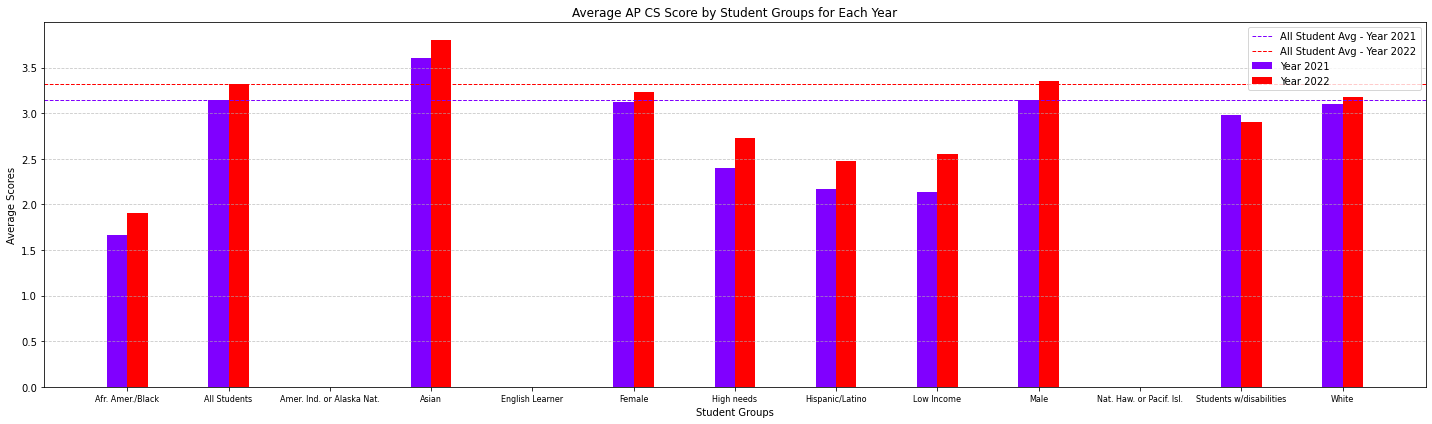

In [ ]:
# Get unique student groups and years
student_groups = df_grouped['Student Group'].unique()
years = df_grouped['Year'].unique()

# Set up colors for each year
colors = plt.cm.rainbow(np.linspace(0, 1, len(years)))

# Create a wider figure
plt.figure(figsize=(20, 6))

# Plot each year's data in a grouped bar plot
bar_width = 0.2
for i, year in enumerate(years):
    year_data = df_grouped[df_grouped['Year'] == year]
    average_scores = year_data['Weighted Avg Score']
    
    # Plot a bar for each student group in the current year
    plt.bar(np.arange(len(student_groups)) + i * bar_width, average_scores, width=bar_width, label=f'Year {year}', color=colors[i])

# Add horizontal dotted lines for every year's average for "All Students" group with different colors
line_colors = plt.cm.rainbow(np.linspace(0, 1, len(years)))
for i, year in enumerate(years):
    all_student_avg = df_grouped[(df_grouped['Year'] == year) & (df_grouped['Student Group'] == 'All Students')]['Weighted Avg Score'].values[0]
    plt.axhline(y=all_student_avg, linestyle='--', color=line_colors[i], linewidth=1, label=f'All Student Avg - Year {year}')

# Set plot properties
plt.title('Average AP CS Score by Student Groups for Each Year')
plt.xlabel('Student Groups')
plt.ylabel('Average Scores')
plt.xticks(np.arange(len(student_groups)) + bar_width * (len(years) - 1) / 2, student_groups, rotation=0, ha='center', fontsize=8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


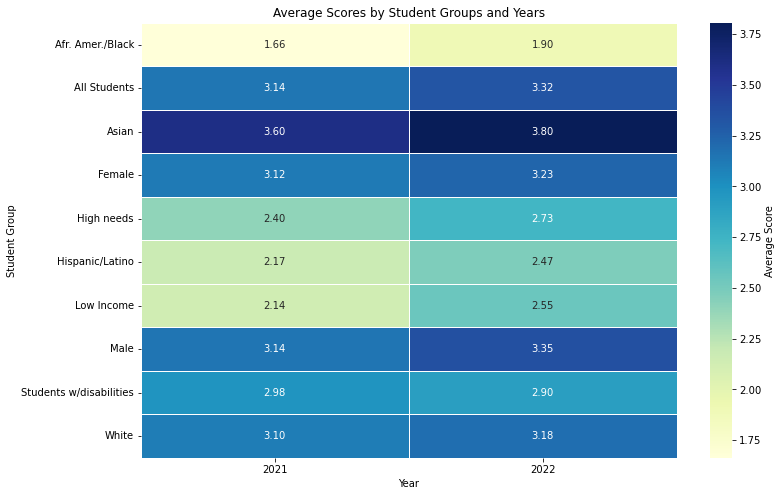

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the weighted average score for each group and year
score_columns = ['Score=1', 'Score=2', 'Score=3', 'Score=4', 'Score=5']
numerator = np.sum(df_grouped[score_columns] * np.array([1, 2, 3, 4, 5]), axis=1)
denominator = np.sum(df_grouped[score_columns], axis=1)
df_grouped['Weighted Avg Score'] = np.where(denominator > 0, numerator / denominator, np.nan)

# Create a new DataFrame with student groups as rows, years as columns, and average scores as values
avg_score_df = df_grouped.pivot_table(index='Student Group', columns='Year', values='Weighted Avg Score', aggfunc='mean')

# Sort the columns (years) in ascending order
avg_score_df = avg_score_df.reindex(sorted(avg_score_df.columns), axis=1)

# Create a heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(avg_score_df, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5, cbar_kws={"label": "Average Score"})
plt.title('Average Scores by Student Groups and Years')
plt.xlabel('Year')
plt.ylabel('Student Group')
plt.show()
